In [52]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from celmech.nbody_simulation_utilities import align_simulation
from celmech.secular import SecularSystemSimulation,SecularSystemRKIntegrator
import rebound as rb
import time

In [2]:
def get_sim(scale= 0.05):
    sim = rb.Simulation()
    sim.add(m=1)
    for i in range(1,4):
        sim.add(m=i * 1e-5 , a = 2**i, 
                e = np.random.rayleigh(scale),
                inc = np.random.rayleigh(scale),
                l = 'uniform',
                pomega = 'uniform',
                Omega = 'uniform'
               )
    sim.move_to_com()
    align_simulation(sim)
    return sim

# Initialize simulation objects and evolution operators

In [35]:
np.random.seed(0)
#sim = get_sim()
sa  = rb.SimulationArchive('./sa_secular.bin')
sim = sa[0]
p0 = sim.particles[0]
p = sim.particles[1]
amd1 = p.m * np.sqrt(sim.G*p0.m) * (np.sqrt(p.a) - np.sqrt(p.a*(1-p.e**2))*np.cos(p.inc))
sec_sim = SecularSystemRKIntegrator.from_Simulation(
    sim,
    dtFraction= 1, 
    max_order=4,
    DFOp_kwargs={'rtol':1e-10,'atol':1e-10 * np.sqrt(amd1),'max_iter':10}
)

In [85]:
def setup_sim(sim,method,dt,init_vec):
    sim.t = 0
    sim.update_state_from_vector(init_vec)
    sim.nonlinearSecOp.rkmethod = method
    sim.dt = dt
def run_sim(sim,Trun,Nout):
    times = np.linspace(sim.t,sim.t + Trun, Nout)
    timesDone,E,AMD = np.zeros((3,Nout))
    for i,t in enumerate(times):
        sim.integrate(t)
        timesDone[i] = sim.t
        E[i]=sim.calculate_energy()
        AMD[i]=sim.calculate_AMD()
    dE = (E-E[0])/E[0]
    dAMD = (AMD-AMD[0])/AMD[0]
    return timesDone,dE,dAMD
def time_sim(sim,Trun):
    start = time.time()
    sim.integrate(sim.t + Trun)
    end = time.time()
    return end-start

In [63]:
rk_methods = ['ImplicitMidpoint','LobattoIIIB','GL4','GL6']
hFracs = np.logspace(-2.5,-0.5,10)
sv0 = np.copy(sec_sim.state_vector)
E0 = sec_sim.calculate_energy()
AMD0 = sec_sim.calculate_AMD()
Tsec = sec_sim.Tsec
Trun = 4 * Tsec
results = dict()
for method in rk_methods:
    for hf in hFracs:
        setup_sim(sec_sim,method,hf * Tsec,sv0)
        timesDone,dE,dAMD = run_sim(sec_sim,Trun,12)
        runtime = time_sim(sec_sim,Trun)
        results[(method,hf)] = (runtime,dE,dAMD)

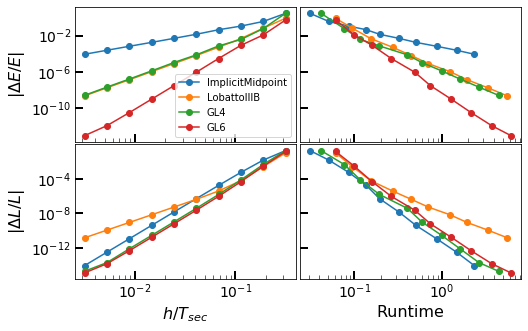

In [73]:
fig,ax = plt.subplots(2,2,sharex='col',sharey='row',figsize=(8,5))

for method in rk_methods:
    runtimes = np.array([results[(method,hf)][0] for hf in hFracs])
    dEs = np.array([results[(method,hf)][1] for hf in hFracs])
    dAMDs = np.array([results[(method,hf)][2] for hf in hFracs])
    
    dEs_max = np.max(np.abs(dEs),axis=1)
    dAMDs_max = np.max(np.abs(dAMDs),axis=1)
    

    ax[0,0].plot(hFracs,dEs_max,'o-',label=method)
    ax[1,0].plot(hFracs,dAMDs_max,'o-',label=method)

    ax[0,1].plot(runtimes,dEs_max,'o-',label=method)
    ax[1,1].plot(runtimes,dAMDs_max,'o-',label=method)

for row in ax:
    for a in row:
        a.set_xscale('log')
        a.set_yscale('log')
        plt.sca(a)
        plt.tick_params(direction='in',size=8,width=2,labelsize=14)
        plt.tick_params(direction='in',size=4,which='minor')
ax[0,0].set_ylabel(r"$|\Delta E/E|$",fontsize=16)
ax[1,0].set_ylabel(r"$|\Delta L/L|$",fontsize=16)
ax[0,0].legend()    
ax[1,0].set_xlabel(r"$h / T_{sec}$",fontsize=16)
ax[1,1].set_xlabel(r"Runtime",fontsize=16)
plt.subplots_adjust(hspace=0.02,wspace=0.02)

In [74]:
def run_splitting_sim(sim,Trun,Nout,corrector):
    times = np.linspace(sim.t,sim.t + Trun, Nout)
    timesDone,E,AMD = np.zeros((3,Nout))
    for i,t in enumerate(times):
        sim.integrate(t,corrector=corrector)
        timesDone[i] = sim.t
        E[i]=sim.calculate_energy()
        AMD[i]=sim.calculate_AMD()
    dE = (E-E[0])/E[0]
    dAMD = (AMD-AMD[0])/AMD[0]
    return timesDone,dE,dAMD

def time_splitting_sim(sim,Trun,corrector):
    start = time.time()
    sim.integrate(sim.t + Trun,corrector=corrector)
    end = time.time()
    return end-start

In [86]:
sec_sim_split = SecularSystemSimulation.from_Simulation(
    sim,
    dtFraction= 1, 
    max_order=4,
    DFOp_kwargs={'rkmethod':'ImplicitMidpoint','rtol':1e-10,'atol':1e-10 * amd1,'max_iter':10}
)
results_split=dict()
for method in ['ImplicitMidpoint','GL4']:
    for corrector in [True,False]:
        for hf in hFracs:
            setup_sim(sec_sim_split,method,hf * Tsec,sv0)
            timesDone,dE,dAMD = run_splitting_sim(sec_sim_split,Trun,12,corrector=corrector)
            runtime = time_splitting_sim(sec_sim_split,Trun,corrector=corrector)
            results_split[(method,corrector,hf)] = (runtime,dE,dAMD)

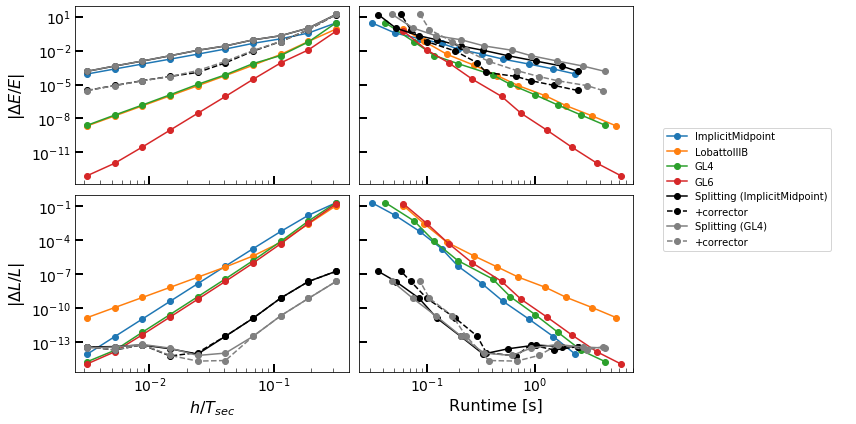

In [108]:
#fig,ax = plt.subplots(2,2,sharex='col',sharey='row',figsize=(8,5))
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(12,6))
gspec = GridSpec(2,3,width_ratios=[2,2,1.5],figure=fig)
axes = []

row1 =[fig.add_subplot(gspec[0,0])]
row1.append(fig.add_subplot(gspec[0,1],sharey=row1[0]))

row2=[fig.add_subplot(gspec[1,0],sharex=row1[0])]
row2.append(fig.add_subplot(gspec[1,1],sharex=row1[1],sharey=row2[0]))

ax = np.array([row1,row2])
lgnd_ax = fig.add_subplot(gspec[:,2])
proxy = []
lbls = []
#######################
### RK Integrations ###
#######################
for method in rk_methods:
    runtimes = np.array([results[(method,hf)][0] for hf in hFracs])
    dEs = np.array([results[(method,hf)][1] for hf in hFracs])
    dAMDs = np.array([results[(method,hf)][2] for hf in hFracs])
    
    dEs_max = np.max(np.abs(dEs),axis=1)
    dAMDs_max = np.max(np.abs(dAMDs),axis=1)
    

    l,=ax[0,0].plot(hFracs,dEs_max,'o-')
    ax[1,0].plot(hFracs,dAMDs_max,'o-')

    ax[0,1].plot(runtimes,dEs_max,'o-')
    ax[1,1].plot(runtimes,dAMDs_max,'o-')
    proxy.append(l)
    lbls.append(method)

##############################
### Splitting Integrations ###
##############################
for color,method in zip(['black','gray'],['ImplicitMidpoint','GL4']):
    for ls,lbl,corrector in zip(['-','--'],['Splitting ({:s})'.format(method),'+corrector'],[False,True]):
        runtimes = np.array([results_split[(method,corrector,hf)][0] for hf in hFracs])
        dEs = np.array([results_split[(method,corrector,hf)][1] for hf in hFracs])
        dAMDs = np.array([results_split[(method,corrector,hf)][2] for hf in hFracs])

        dEs_max = np.max(np.abs(dEs),axis=1)
        dAMDs_max = np.max(np.abs(dAMDs),axis=1)

        l,=ax[0,0].plot(hFracs,dEs_max,ls=ls,color=color,marker='o')
        ax[1,0].plot(hFracs,dAMDs_max,ls=ls,color=color,marker='o')

        ax[0,1].plot(runtimes,dEs_max,ls=ls,color=color,marker='o')
        ax[1,1].plot(runtimes,dAMDs_max,ls=ls,color=color,marker='o')
        
        proxy.append(l)
        lbls.append(lbl)


##################################
### Labels and plot parameters ###
##################################
for i,row in enumerate(ax):
    for j,a in enumerate(row):
        a.set_xscale('log')
        a.set_yscale('log')
        plt.sca(a)
        plt.tick_params(direction='in',size=8,width=2,labelsize=14)
        plt.tick_params(direction='in',size=4,which='minor')
        if j>0:
            plt.setp(a.get_yticklabels(),visible=False)
        if i==0:
            plt.setp(a.get_xticklabels(),visible=False)

        
ax[0,0].set_ylabel(r"$|\Delta E/E|$",fontsize=16)
ax[1,0].set_ylabel(r"$|\Delta L/L|$",fontsize=16)
ax[1,0].set_xlabel(r"$h / T_{sec}$",fontsize=16)
ax[1,1].set_xlabel(r"Runtime [s]",fontsize=16)
plt.subplots_adjust(hspace=0.02,wspace=0.02)



lgnd_ax.set_frame_on(False)
lgnd_ax.get_xaxis().set_visible(False)
lgnd_ax.get_yaxis().set_visible(False)
lgnd_ax.legend(proxy,lbls,loc='center')

plt.tight_layout()
plt.savefig("/Users/shadden/DropboxSmithsonian/Apps/ShareLaTeX/Celmech/secular_intergrators_compare.pdf")